In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import getpass
username = getpass.getuser()

import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(username))
import bandit_modeling as bm

%matplotlib inline

In [2]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
data = data[data['Condition']=='80-20']
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
106400,0,Baby,01112018_Baby,11.0,11.0,5.0,2.0,-2.0,0.0,1.0,...,0.566,1.544,0.560,0.0,1.0,1.0,1.0,80-20,1.0,13.0
106401,1,Baby,01112018_Baby,12.0,12.0,6.0,1.0,1.0,0.0,1.0,...,0.560,2.506,0.497,0.0,0.0,1.0,1.0,80-20,1.0,13.0
106402,2,Baby,01112018_Baby,13.0,0.0,7.0,2.0,2.0,0.0,0.0,...,0.497,2.526,0.562,0.0,0.0,0.0,0.0,80-20,2.0,53.0
106403,3,Baby,01112018_Baby,14.0,1.0,0.0,3.0,-1.0,1.0,0.0,...,0.562,1.780,0.587,0.0,0.0,0.0,0.0,80-20,2.0,53.0
106404,4,Baby,01112018_Baby,15.0,2.0,0.0,4.0,-2.0,0.0,1.0,...,0.587,4.313,0.382,1.0,1.0,1.0,1.0,80-20,2.0,53.0


### make some new dataframes
    X has predictor variables (choice and reward history for past n trials) relevant variables for logit model
    Y has dependent variable (choice on current trial)

In [7]:
X_value_history, y_value_history, c = bm.feature_history(data, X_dataframe='value', y_dataframe='choice')

In [8]:
Y_switch_right = data['Decision'] + data['Switch'] == 2
Y_switch_left = data['Decision'].values + data['Switch']*2 == 2
Y_switch_full = data['Switch']

#Y_switch_right_history = (choice_history.drop('10_Port',axis=1).values + switch_history.values) == 2
#Y_switch_left_history = (choice_history.drop('10_Port', axis=1).values + switch_history.values*2) == 2

In [9]:
metrics_db = []
decision_boundaries = np.arange(0,1,0.05)
for boundary in decision_boundaries:
    temp_predict = lr1_proba_R[:,1]>boundary
    metrics_temp = sklearn.metrics.precision_recall_fscore_support(y_test, temp_predict)
    metrics_db.append(metrics_temp)

NameError: name 'lr1_proba_R' is not defined

In [ ]:
# some code for optimizing parameters, come back to later

penalty = ['l1', 'l2']
C = np.logspace(0,4,10)
hyperparameters = dict(C=C, penalty=penalty)
lr_gridsearch = sklearn.model_selection.GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)
    
best_model = lr_gridsearch.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_predict = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

### lr3 - use action value to predict choice

In [10]:
'''LEFT'''
X_train, X_test, y_train, y_test = train_test_split(X_value_history, Y_switch_left, test_size=0.3, random_state=1)

lr3 = LogisticRegression()
lr3.fit(X_train, y_train)

lr3_proba_L = lr3.predict_proba(X_test)
lr3_predict_L = lr3.predict(X_test)

score_lr3_L = lr3.score(X_test, y_test)
metrics_lr3_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr3_predict_L)


'''RIGHT'''
X_train, X_test, y_train, y_test = train_test_split(X_value_history, Y_switch_right, test_size=0.3, random_state=1)

lr3 = LogisticRegression()
lr3.fit(X_train, y_train)

lr3_proba_R = lr3.predict_proba(X_test)
lr3_predict_R = lr3.predict(X_test)

score_lr3_R = lr3.score(X_test, y_test)
metrics_lr3_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr3_predict_R)

'''INTEGRATED'''
X_train, X_test, y_train, y_test_full = train_test_split(X_value_history, Y_switch_full, test_size=0.3, random_state=1)

y_proba = np.array([max(lr3_proba_L[i,1], lr3_proba_R[i,1]) for i in range(lr3_proba_L.shape[0])])
y_predict = y_proba[:]>0.2
np.sum(y_predict)
metrics_lr3 = sklearn.metrics.precision_recall_fscore_support(y_test_full, y_predict)

lr3_score = 1-np.abs(y_predict-y_test_full).sum()/len(y_test_full)


/Users/celiaberon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


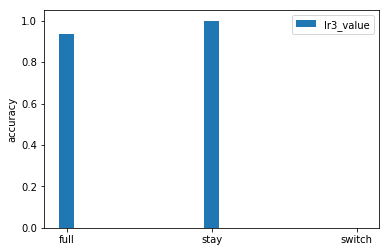

In [13]:
height_c = [lr3_score, metrics_lr3[1][0], metrics_lr3[1][1]]

barWidth = 0.1
# The x position of bars
r1 = np.arange(len(height_c))

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_c, width=barWidth, label='lr3_value')

plt.xticks(range(len(height_c)), conditions)
plt.ylabel('accuracy')
plt.legend()

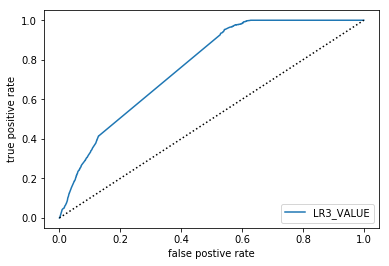

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, lr3_proba_R[:,1])
plt.plot(fpr, tpr, label="LR3_VALUE")

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')

plt.legend(loc='lower right')